In [1]:
!pip install --upgrade transformers
!pip install transformers bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.9 MB/s eta 0:00:00


In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSeq2SeqLM
from bertviz import model_view, head_view
import torch
from bertviz import model_view

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Babelscape/rebel-large"

#Load config and force eager attention
config = AutoConfig.from_pretrained(model_name)
config._attn_implementation = "eager"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config).to(device)
model.eval()

#Function to ensure the inputs are torch tensors
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    if isinstance(x, (list, tuple)):
        elems = [to_tensor(e) for e in x]
        return torch.stack(elems, dim=0)
    raise ValueError(f"Unsupported type: {type(x)}")

def get_generated_ids(gen_output):
    if isinstance(gen_output, torch.Tensor):
        return gen_output
    if hasattr(gen_output, "sequences"):
        return gen_output.sequences
    if isinstance(gen_output, (list, tuple)) and isinstance(gen_output[0], torch.Tensor):
        return gen_output[0]
    raise ValueError("Unable to extract sequences")

def normalize_token(t):
    return t.replace("Ġ", "").replace("▁", "").replace("##", "").strip()

def find_subtoken_positions(entity_text, src_tokens, tokenizer):
    if not entity_text:
        return []
    ent_ids = tokenizer(entity_text, add_special_tokens=False)["input_ids"]
    ent_tokens = tokenizer.convert_ids_to_tokens(ent_ids)
    norm_src = [normalize_token(t) for t in src_tokens]
    norm_ent = [normalize_token(t) for t in ent_tokens]

    #exact subsequence
    for i in range(len(src_tokens) - len(norm_ent) + 1):
        if norm_src[i:i+len(norm_ent)] == norm_ent:
            return list(range(i, i+len(norm_ent)))

    # fallback: greedy matching
    positions = []
    for nt in norm_ent:
        for i, s in enumerate(norm_src):
            if nt in s and i not in positions:
                positions.append(i)
                break
    return positions

#function for computing the attention focus on the entity
def compute_entity_focus(sentence, model, tokenizer, max_len=128, debug=False):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    gen_out = model.generate(
        **inputs,
        max_length=max_len,
        num_beams=4,
        early_stopping=True,
        return_dict_in_generate=True
    )
    gen_ids = get_generated_ids(gen_out).to(device)
    gen_text = tokenizer.batch_decode(gen_ids, skip_special_tokens=False)[0]

    #Forward pass with output_attentions=True
    with torch.no_grad():
        forward = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask"),
            decoder_input_ids=gen_ids,
            output_attentions=True,
            return_dict=True
        )

    #Cross-attention from last layer
    cross_attn_all = to_tensor(forward.cross_attentions)
    last_layer = cross_attn_all[-1]
    avg_heads = last_layer.mean(dim=1)
    attn_matrix = avg_heads[0].cpu().numpy()

    src_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(gen_ids[0].cpu().tolist())

    #Entity extraction from generated text
    triplets = []
    if "<triplet>" in gen_text:
        for p in gen_text.split("<triplet>")[1:]:
            p = p.replace("</s>", "").replace("<s>", "").strip()
            subj, rel, obj = "", "", ""
            if "<subj>" in p and "<obj>" in p:
                before_subj, after_subj = p.split("<subj>", 1)
                subj = before_subj.strip()
                if "<obj>" in after_subj:
                    obj, rel = after_subj.split("<obj>", 1)
                    obj, rel = obj.strip(), rel.strip()
            triplets.append({"subject": subj, "relation": rel, "object": obj})

    #locate entities in source tokens
    entity_positions = []
    for t in triplets:
        for ent in [t["subject"], t["object"]]:
            pos = find_subtoken_positions(ent, src_tokens, tokenizer)
            entity_positions.extend(pos)
    entity_positions = sorted(set(entity_positions))

    if len(entity_positions) == 0:
        efr = 0.0
        per_step = [0.0] * attn_matrix.shape[0]
    else:
        efr = float(attn_matrix[:, entity_positions].sum() / (attn_matrix.sum() + 1e-12))
        per_step = [
            float(attn_matrix[t, entity_positions].sum() / (attn_matrix[t].sum() + 1e-12))
            for t in range(attn_matrix.shape[0])
        ]

    return {
        "sentence": sentence,
        "gen_text": gen_text,
        "triplets": triplets,
        "src_tokens": src_tokens,
        "tgt_tokens": tgt_tokens,
        "entity_positions": entity_positions,
        "efr": efr,
        "per_step": per_step
    }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Processing: Barack Obama was born in Honolulu.
Generated: <s><triplet> Barack Obama <subj> Honolulu <obj> place of birth</s>
Triplets: [{'subject': 'Barack Obama', 'relation': 'place of birth', 'object': 'Honolulu'}]
Entity positions: [1, 2, 3, 7]
EFR: 0.08922743052244186
RFR: 0.9107725694775581
--------------------------------------------------
Processing: Barack Obama was born in Honolulu and served as the 44th President of the United States.
Generated: <s><triplet> Barack Obama <subj> Honolulu <obj> place of birth <subj> President of the United States <obj> position held</s>
Triplets: [{'subject': 'Barack Obama', 'relation': 'place of birth <subj> President of the United States <obj> position held', 'object': 'Honolulu'}]
Entity positions: [1, 2, 3, 7]
EFR: 0.046804849058389664
RFR: 0.9531951509416103
--------------------------------------------------
Processing: Barack Obama was born in Honolulu, married to Michelle Obama and served as the 44th President of the United States.
Gener

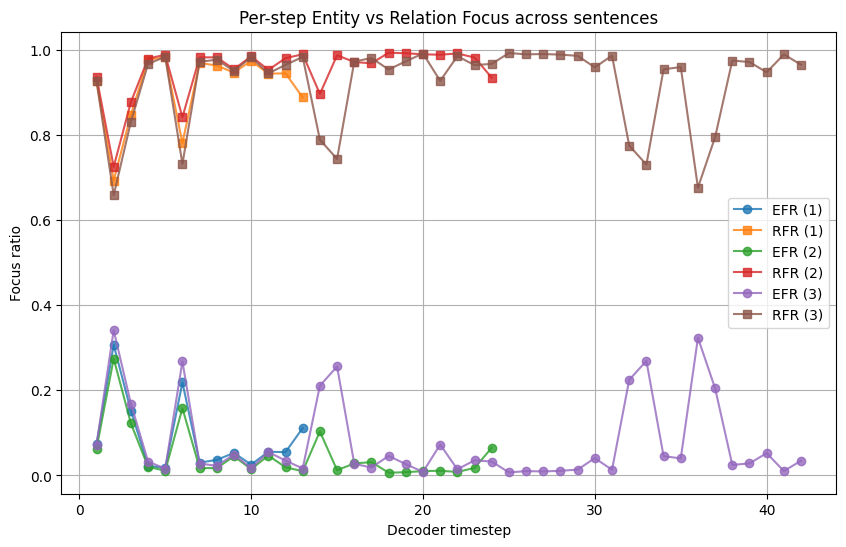

In [6]:
#Example sentences
sentences = [
    "Barack Obama was born in Honolulu.",
    "Barack Obama was born in Honolulu and served as the 44th President of the United States.",
    "Barack Obama was born in Honolulu, married to Michelle Obama and served as the 44th President of the United States."
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Isaac Newton formulated the law of gravity.
Generated: <s><triplet> law of gravity <subj> Isaac Newton <obj> discoverer or inventor</s>
Triplets: [{'subject': 'law of gravity', 'relation': 'discoverer or inventor', 'object': 'Isaac Newton'}]
Entity positions: [1, 2, 3, 6, 7, 8]
EFR: 0.13135123252868652
RFR: 0.8686487674713135
--------------------------------------------------
Processing: Isaac Newton formulated the law of gravity and developed calculus.
Generated: <s><triplet> law of gravity <subj> Isaac Newton <obj> discoverer or inventor <triplet> calculus <subj> Isaac Newton <obj> discoverer or inventor</s>
Triplets: [{'subject': 'law of gravity', 'relation': 'discoverer or inventor', 'object': 'Isaac Newton'}, {'subject': 'calculus', 'relation': 'discoverer or inventor', 'object': 'Isaac Newton'}]
Entity positions: [1, 2, 3, 6, 7, 8, 11]
EFR: 0.11671465635299683
RFR: 0.8832853436470032
--------------------------------------------------
Processing: Isaac Newton formulate

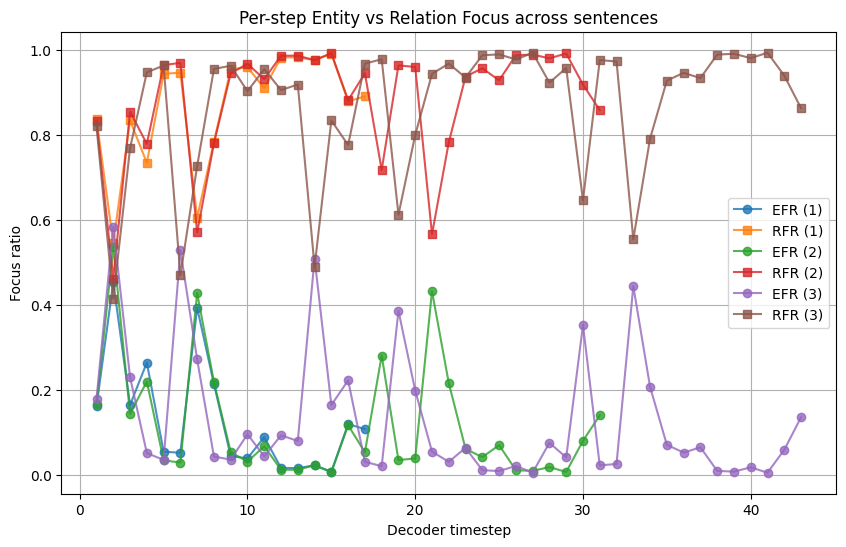

In [7]:
#Example sentences
sentences = [
    "Isaac Newton formulated the law of gravity.",
    "Isaac Newton formulated the law of gravity and developed calculus.",
    "Isaac Newton formulated the law of gravity, developed calculus, and became President of the Royal Society."
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Frida Kahlo was born in Mexico City.
Generated: <s><triplet> Frida Kahlo <subj> Mexico City <obj> place of birth</s>
Triplets: [{'subject': 'Frida Kahlo', 'relation': 'place of birth', 'object': 'Mexico City'}]
Entity positions: [1, 2, 3, 4, 8, 9]
EFR: 0.13528090715408325
RFR: 0.8647190928459167
--------------------------------------------------
Processing: Frida Kahlo was born in Mexico City and became a renowned painter.
Generated: <s><triplet> Frida Kahlo <subj> Mexico City <obj> place of birth</s>
Triplets: [{'subject': 'Frida Kahlo', 'relation': 'place of birth', 'object': 'Mexico City'}]
Entity positions: [1, 2, 3, 4, 8, 9]
EFR: 0.12404358386993408
RFR: 0.8759564161300659
--------------------------------------------------
Processing: Frida Kahlo was born in Mexico City and became a renowned painter, however suffered from lifelong health issues.
Generated: <s><triplet> Frida Kahlo <subj> Mexico City <obj> place of birth</s>
Triplets: [{'subject': 'Frida Kahlo', 'relati

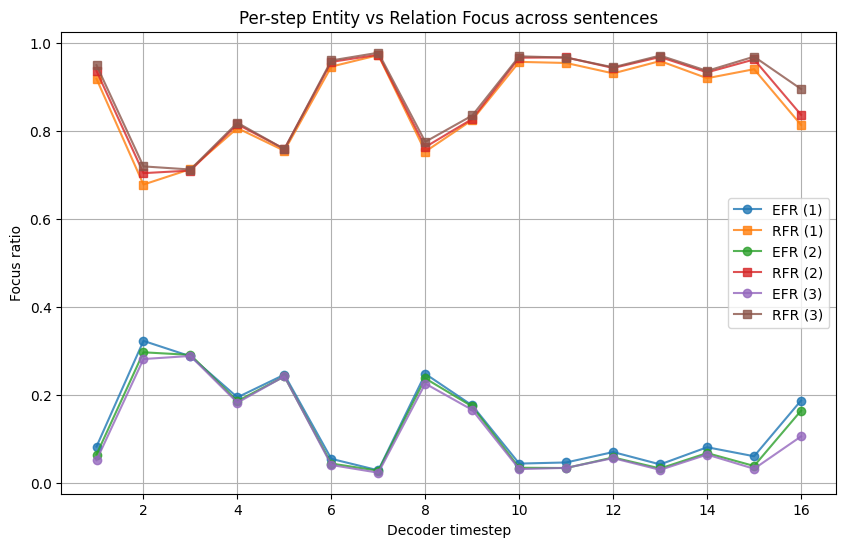

In [8]:
#Example sentences
sentences = [
    "Frida Kahlo was born in Mexico City.",
    "Frida Kahlo was born in Mexico City and became a renowned painter.",
    "Frida Kahlo was born in Mexico City and became a renowned painter, however suffered from lifelong health issues."
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Albert Einstein was born in Ulm, Germany.
Generated: <s><triplet> Albert Einstein <subj> Ulm <obj> place of birth</s>
Triplets: [{'subject': 'Albert Einstein', 'relation': 'place of birth', 'object': 'Ulm'}]
Entity positions: [1, 2, 6, 7]
EFR: 0.12000776827335358
RFR: 0.8799922317266464
--------------------------------------------------
Processing: Albert Einstein was born in Ulm, Germany and developed the theory of relativity.
Generated: <s><triplet> Albert Einstein <subj> Ulm <obj> place of birth <subj> theory of relativity <obj> notable work <triplet> theory of relativity <subj> Albert Einstein <obj> discoverer or inventor</s>
Triplets: [{'subject': 'Albert Einstein', 'relation': 'place of birth <subj> theory of relativity <obj> notable work', 'object': 'Ulm'}, {'subject': 'theory of relativity', 'relation': 'discoverer or inventor', 'object': 'Albert Einstein'}]
Entity positions: [1, 2, 6, 7, 12, 13, 14, 15]
EFR: 0.12587539851665497
RFR: 0.874124601483345
--------------

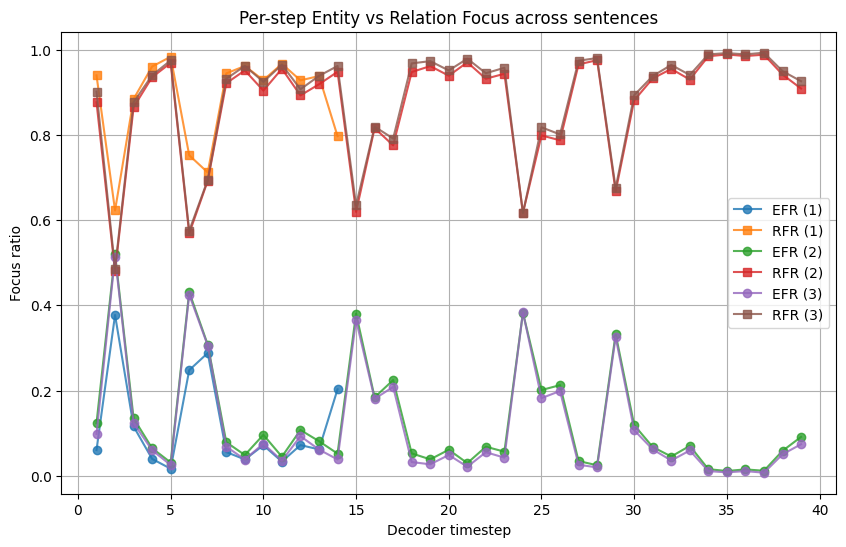

In [9]:
#Example sentences
sentences = [
    "Albert Einstein was born in Ulm, Germany.",
    "Albert Einstein was born in Ulm, Germany and developed the theory of relativity.",
    "Albert Einstein was born in Ulm, Germany, worked at the Swiss Patent Office, and developed the theory of relativity."
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Nelson Mandela spent 27 years in prison.
Generated: <s><triplet> 27 years in prison <subj> Nelson Mandela <obj> facet of</s>
Triplets: [{'subject': '27 years in prison', 'relation': 'facet of', 'object': 'Nelson Mandela'}]
Entity positions: [1, 2, 3, 5, 6, 7, 8]
EFR: 0.2036331593990326
RFR: 0.7963668406009674
--------------------------------------------------
Processing: Nelson Mandela spent 27 years in prison and became President of South Africa.
Generated: <s><triplet> Nelson Mandela <subj> President of South Africa <obj> position held</s>
Triplets: [{'subject': 'Nelson Mandela', 'relation': 'position held', 'object': 'President of South Africa'}]
Entity positions: [1, 2, 3, 11, 12, 13, 14]
EFR: 0.13852600753307343
RFR: 0.8614739924669266
--------------------------------------------------
Processing: Nelson Mandela spent 27 years in prison, became President of South Africa, and won the Nobel Peace Prize.
Generated: <s><triplet> Nelson Mandela <subj> Nobel Peace Prize <obj

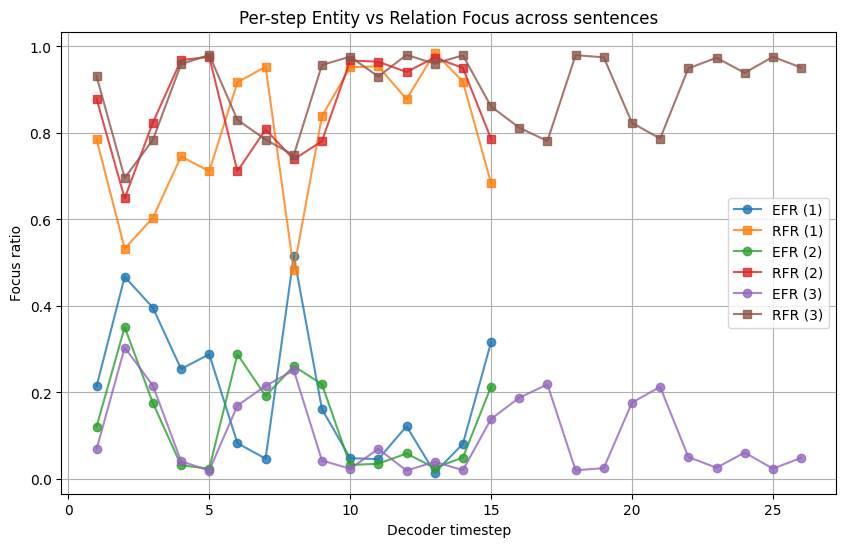

In [10]:
#Example sentences
sentences = [
    "Nelson Mandela spent 27 years in prison.",
    "Nelson Mandela spent 27 years in prison and became President of South Africa.",
    "Nelson Mandela spent 27 years in prison, became President of South Africa, and won the Nobel Peace Prize."
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Jane Austen wrote Pride and Prejudice.
Generated: <s><triplet> Pride and Prejudice <subj> Jane Austen <obj> author</s>
Triplets: [{'subject': 'Pride and Prejudice', 'relation': 'author', 'object': 'Jane Austen'}]
Entity positions: [1, 2, 3, 5, 6, 7, 8, 9]
EFR: 0.2082023024559021
RFR: 0.7917976975440979
--------------------------------------------------
Processing: Jane Austen wrote Pride and Prejudice and lived in England.
Generated: <s><triplet> Pride and Prejudice <subj> Jane Austen <obj> author</s>
Triplets: [{'subject': 'Pride and Prejudice', 'relation': 'author', 'object': 'Jane Austen'}]
Entity positions: [1, 2, 3, 5, 6, 7, 8, 9]
EFR: 0.18473416566848755
RFR: 0.8152658343315125
--------------------------------------------------
Processing: Jane Austen wrote Pride and Prejudice, lived in England, and influenced English literature profoundly.
Generated: <s><triplet> Pride and Prejudice <subj> Jane Austen <obj> author</s>
Triplets: [{'subject': 'Pride and Prejudice', 're

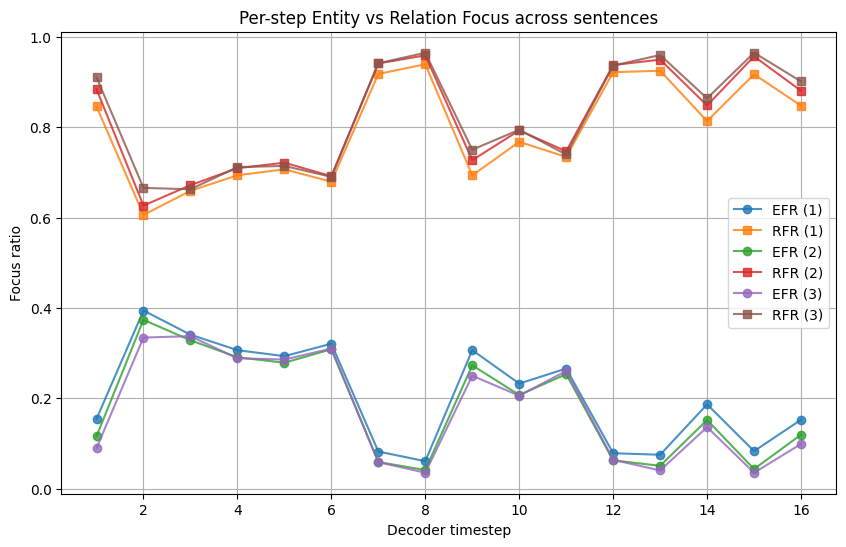

In [11]:
#Example sentences
sentences = [
    "Jane Austen wrote Pride and Prejudice.",
    "Jane Austen wrote Pride and Prejudice and lived in England.",
    "Jane Austen wrote Pride and Prejudice, lived in England, and influenced English literature profoundly."
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()